In [7]:
import pickle
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [8]:
data = pd.read_csv("heart_dataset_3.csv")

split_data = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=32)
for train_index, test_index in split_data.split(data, data['target']):
    train_set = data.loc[train_index]
    test_set = data.loc[test_index]

#splitting for train set data
Ftrs_train = train_set.drop(columns='target', axis=1)
Trgt_train = train_set['target']

#splitting for test set data
Ftrs_test = test_set.drop(columns='target', axis=1)
Trgt_test = test_set['target']

##### BEST PERFORMING MODELS (Top 5):

``` 
Rank       Name                       Variable Name
----------------------------------------------------
1.    MLP Neural Network               model_mlp 
2.    Support Vector Machine           model_svm
3.    Logistic Regression              model_logreg
4.    Gaussian Naive Bayes             model_gnb
5.    Bernoulli Naive Bayes            model_bnb
```

In [9]:
model_mlp=pickle.load(open('trained_mlp.sav', 'rb'))
model_svm=pickle.load(open('trained_svm.sav', 'rb'))
model_logreg=pickle.load(open('trained_logreg.sav', 'rb'))
model_gnb=pickle.load(open('trained_gnb.sav', 'rb'))
model_bnb=pickle.load(open('trained_bnb.sav', 'rb'))

C:\Users\Pritam\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator LabelBinarizer from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Pritam\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator MLPClassifier from version 1.3.0 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Pritam\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator SVC from version 1.3.0 when using version 1.2.2. This might lead to break

### Confidence Scores for the models

In [10]:
cs_mlp=model_mlp.predict_proba(Ftrs_test)
cs_svm=model_svm.predict_proba(Ftrs_test)
cs_logreg=model_logreg.predict_proba(Ftrs_test)
cs_gnb=model_gnb.predict_proba(Ftrs_test)
cs_bnb=model_bnb.predict_proba(Ftrs_test)

### Applying Sugeno Fuzzy Integral based Ensemble Method

In [11]:
def find_max(arr):
    class_0=arr[0]
    class_1=arr[1]

    if class_0>class_1:
        return 0
    elif class_0<class_1:
        return 1
    else:
        return 1

In [12]:
from sympy.solvers import solve
from sympy import Symbol
def sugeno(solution,pred1,pred2,pred3, labels):
    fuzzymeasures = np.array([solution[0],solution[1],solution[2]])
    l = Symbol('l', real = True)
    lam = solve(  ( 1 + l* fuzzymeasures[0]) * ( 1 + l* fuzzymeasures[1]) *( 1 + l* fuzzymeasures[2]) - (l+1), l )
    if len(lam) < 3:
      lam = np.asarray(lam)
    else:
      if lam[0] >= 0:
          lam = np.asarray(lam[0])
      elif lam[1] >= 0:
          lam = np.asarray(lam[1])
      elif lam[2] >= 0:
          lam = np.asarray(lam[2])
    
    Ypred_fuzzy = np.zeros(shape = pred1.shape, dtype = float)
    for sample in range(0,pred1.shape[0]):
        for classes in range(0,2):
            scores = np.array([pred1[sample][classes],pred2[sample][classes],pred3[sample][classes]])
            permutedidx = np.flip(np.argsort(scores))
            scoreslambda = scores[permutedidx]
            fmlambda = fuzzymeasures[permutedidx]
            ge_prev = fmlambda[0]
            fuzzyprediction = min((scoreslambda[0], fmlambda[0]))
            for i in range(1,3):
                ge_curr = ge_prev + fmlambda[i] + lam * fmlambda[i] * ge_prev
                fuzzyprediction = max((fuzzyprediction,min((scoreslambda[i],ge_curr))))
                ge_prev = ge_curr

            Ypred_fuzzy[sample][classes] = fuzzyprediction
            


    
    ypred_fuzzy = np.argmax(Ypred_fuzzy, axis=1)
    pred_label = []
    for i in ypred_fuzzy:
      label = np.zeros((2))
      label[i] = label[i]+1
      pred_label.append(label)
    pred_label = np.array(pred_label)
    

    sugeno_predict=[]
    for i in range(len(pred_label)):
        arr=[]
        arr=pred_label[i]
        ans=find_max(arr)
        sugeno_predict.append(ans)
        
    
    
    acc = accuracy_score(labels,sugeno_predict)
    return acc,ypred_fuzzy,pred_label

ModuleNotFoundError: No module named 'sympy'

In [ ]:
acc, ypred, cs_sugeno = sugeno([0.1,0.2,0.2], cs_mlp, cs_svm, cs_logreg, Trgt_test)

In [ ]:
print("Classification Report")
print(classification_report(Trgt_test,ypred))

print("Accuracy Score: ", acc)

print("ROC-AUC Score: ",roc_auc_score(Trgt_test, ypred))

precision, recall, thresholds = metrics.precision_recall_curve(Trgt_test, ypred)
auc = metrics.auc(recall, precision)
print("PR-AUC Score: ", auc)

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.77      0.85       100
           1       0.81      0.96      0.88       105

    accuracy                           0.87       205
   macro avg       0.88      0.87      0.87       205
weighted avg       0.88      0.87      0.87       205

Accuracy Score:  0.8682926829268293
ROC-AUC Score:  0.865952380952381
PR-AUC Score:  0.8979665430294855


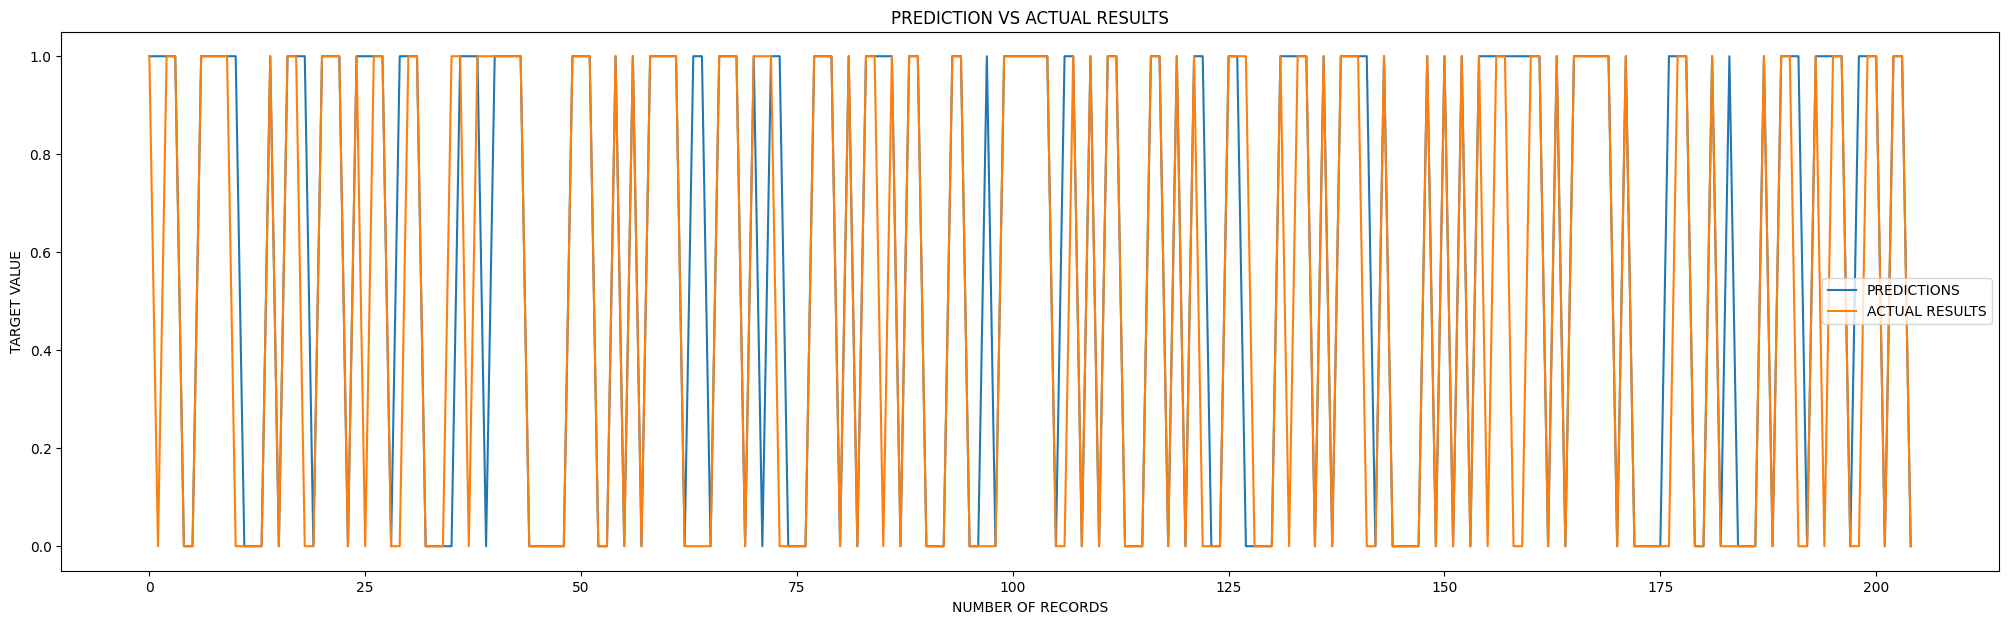

In [ ]:
fig = plt.figure(figsize=(25, 7))
plt.plot(ypred,label="PREDICTIONS")
plt.xlabel("NUMBER OF RECORDS")
plt.ylabel("TARGET VALUE")
test_result=np.array(Trgt_test)
plt.plot(test_result,label="ACTUAL RESULTS")
plt.title("PREDICTION VS ACTUAL RESULTS")
plt.legend()

# sfi(4 class)

In [ ]:
def sugeno(solution,pred1,pred2,pred3,pred4, labels):
    fuzzymeasures = np.array([solution[0],solution[1],solution[2],solution[3]])
    l = Symbol('l', real = True)
    lam = solve(  ( 1 + l* fuzzymeasures[0]) * ( 1 + l* fuzzymeasures[1]) *( 1 + l* fuzzymeasures[2]) *( 1 + l* fuzzymeasures[3]) - (l+1), l )
    if len(lam) < 4:
      lam = np.asarray(lam)
    else:
      if lam[0] >= 0:
          lam = np.asarray(lam[0])
      elif lam[1] >= 0:
          lam = np.asarray(lam[1])
      elif lam[2] >= 0:
          lam = np.asarray(lam[2])
      elif lam[3] >= 0:
          lam = np.asarray(lam[3])
    
    Ypred_fuzzy = np.zeros(shape = pred1.shape, dtype = float)
    for sample in range(0,pred1.shape[0]):
        for classes in range(0,2):
            scores = np.array([pred1[sample][classes],pred2[sample][classes],pred3[sample][classes],pred4[sample][classes]])
            permutedidx = np.flip(np.argsort(scores))
            scoreslambda = scores[permutedidx]
            fmlambda = fuzzymeasures[permutedidx]
            ge_prev = fmlambda[0]
            fuzzyprediction = min((scoreslambda[0], fmlambda[0]))
            for i in range(1,4):
                ge_curr = ge_prev + fmlambda[i] + lam * fmlambda[i] * ge_prev
                fuzzyprediction = max((fuzzyprediction,min((scoreslambda[i],ge_curr))))
                # except ValueError:
                #     sl=scoreslambda.all()
                #fuzzyprediction = max((fuzzyprediction,min((sl,ge_curr))))
                ge_prev = ge_curr

            Ypred_fuzzy[sample][classes] = fuzzyprediction
            


    
    ypred_fuzzy = np.argmax(Ypred_fuzzy, axis=1)
    pred_label = []
    for i in ypred_fuzzy:
      label = np.zeros((2))
      label[i] = label[i]+1
      pred_label.append(label)
    pred_label = np.array(pred_label)
    

    sugeno_predict=[]
    for i in range(len(pred_label)):
        arr=[]
        arr=pred_label[i]
        ans=find_max(arr)
        sugeno_predict.append(ans)
        
    
    
    acc = accuracy_score(labels,sugeno_predict)
    return acc,ypred_fuzzy,pred_label

In [ ]:
# s=1
# l=0
# v,m,l2=0,0,0
# for x in range(1,11):
#     z=x/10
#     for i in range(1,11):
#         jj=i/10
#         for f in range(1,11):
#             k=f/10
#             for g in range(1,11):
#                 gg=g/10
#                 try:             
#                     acc, ypred,label= sugeno([z,jj,k,gg],cs_mlp, cs_svm, cs_logreg,cs_gnb,Trgt_test)
#                     print("\t",acc,"\t",z,"\t",jj,"\t",k,"\t",gg)
#                     print()
#                     if acc>0.8682926829268293:
#                         print("improoved: ","\t",acc,"\t",z,"\t",jj,"\t",k,"\t",gg)
#                         l=jj
#                         m=k
#                         v=z
#                         l2=gg
#                 except ValueError:
#                     pass
            
                
# print("done")
# print(v,l,m,l2)

sfi class 4 optimal measures: 

0.6  1.0  0.5  0.1

 0.1 	 0.8 	 0.5 	 0.5


 0.5 	 0.8 	 0.1 	 0.4

  0.5 	 0.8 	 0.1 	 0.5

   0.6 	 0.7 	 0.4 	 0.1

   0.6 	 0.7 	 0.5 	 0.1

    0.6 	 0.8 	 0.1 	 0.4
    0.6 	 0.8 	 0.1 	 0.5

 0.6 	 1.0 	 0.1 	 0.3
 0.6 	 1.0 	 0.1 	 0.4
 0.6 	 1.0 	 0.1 	 0.5

oreder: cs_mlp, cs_svm, cs_logreg,cs_gnb

In [ ]:
acc, ypred, cs_sugeno = sugeno([0.6, 1.0, 0.5, 0.1], cs_mlp, cs_svm, cs_logreg,cs_gnb,Trgt_test)
# cs_bnb
#0.8682926829268293
print(acc)

0.8731707317073171


In [ ]:
print("Classification Report")
print(classification_report(Trgt_test,ypred))

print("Accuracy Score: ", acc)

print("ROC-AUC Score: ",roc_auc_score(Trgt_test, ypred))

precision, recall, thresholds = metrics.precision_recall_curve(Trgt_test, ypred)
auc = metrics.auc(recall, precision)
print("PR-AUC Score: ", auc)

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.78      0.86       100
           1       0.82      0.96      0.89       105

    accuracy                           0.87       205
   macro avg       0.89      0.87      0.87       205
weighted avg       0.88      0.87      0.87       205

Accuracy Score:  0.8731707317073171
ROC-AUC Score:  0.870952380952381
PR-AUC Score:  0.9012775842044136


# sfi ( 5 class)

In [ ]:
def sugeno(solution,pred1,pred2,pred3,pred4,pred5, labels):
    fuzzymeasures = np.array([solution[0],solution[1],solution[2],solution[3],solution[4]])
    l = Symbol('l', real = True)
    lam = solve(  ( 1 + l* fuzzymeasures[0]) * ( 1 + l* fuzzymeasures[1]) *( 1 + l* fuzzymeasures[2]) *( 1 + l* fuzzymeasures[3]) *( 1 + l* fuzzymeasures[4]) - (l+1), l )
    if len(lam) < 5:
      lam = np.asarray(lam)
    else:
      if lam[0] >= 0:
          lam = np.asarray(lam[0])
      elif lam[1] >= 0:
          lam = np.asarray(lam[1])
      elif lam[2] >= 0:
          lam = np.asarray(lam[2])
      elif lam[3] >= 0:
          lam = np.asarray(lam[3])
      elif lam[4] >= 0:
          lam = np.asarray(lam[4])
    
    Ypred_fuzzy = np.zeros(shape = pred1.shape, dtype = float)
    for sample in range(0,pred1.shape[0]):
        for classes in range(0,2):
            scores = np.array([pred1[sample][classes],pred2[sample][classes],pred3[sample][classes],pred4[sample][classes],pred5[sample][classes]])
            permutedidx = np.flip(np.argsort(scores))
            scoreslambda = scores[permutedidx]
            fmlambda = fuzzymeasures[permutedidx]
            ge_prev = fmlambda[0]
            fuzzyprediction = min((scoreslambda[0], fmlambda[0]))
            for i in range(1,5):
                ge_curr = ge_prev + fmlambda[i] + lam * fmlambda[i] * ge_prev
                fuzzyprediction = max((fuzzyprediction,min((scoreslambda[i],ge_curr))))
                # except ValueError:
                #     sl=scoreslambda.all()
                #fuzzyprediction = max((fuzzyprediction,min((sl,ge_curr))))
                ge_prev = ge_curr

            Ypred_fuzzy[sample][classes] = fuzzyprediction
            


    
    ypred_fuzzy = np.argmax(Ypred_fuzzy, axis=1)
    pred_label = []
    for i in ypred_fuzzy:
      label = np.zeros((2))
      label[i] = label[i]+1
      pred_label.append(label)
    pred_label = np.array(pred_label)
    

    sugeno_predict=[]
    for i in range(len(pred_label)):
        arr=[]
        arr=pred_label[i]
        ans=find_max(arr)
        sugeno_predict.append(ans)
        
    
    
    acc = accuracy_score(labels,sugeno_predict)
    return acc,ypred_fuzzy,pred_label

In [ ]:
# s=1
# l=0
# v,m,l2,l3=0,0,0,0
# for x in range(1,11):
#     z=x/10
#     for i in range(1,11):
#         jj=i/10
#         for f in range(1,11):
#             k=f/10
#             for g in range(1,11):
#                 gg=g/10
#                 for p in range(1,11):
#                     pp=p/10
#                     try:             
#                         acc, ypred,label= sugeno([z,jj,k,gg,pp],cs_mlp, cs_svm, cs_logreg,cs_gnb,cs_bnb,Trgt_test)
#                         print("\t",acc,"\t",z,"\t",jj,"\t",k,"\t",gg)
#                         print()
#                         if acc==0.8682926829268293:
#                             print("tie: ","\t",acc,"\t",z,"\t",jj,"\t",k,"\t",gg)
#                             l=jj
#                             m=k
#                             v=z
#                             l2=gg
#                         if acc>=0.873170731707317:
#                             print("improoved: ","\t",acc,"\t",z,"\t",jj,"\t",k,"\t",gg)
#                             l=jj
#                             m=k
#                             v=z
#                             l2=gg
#                     except ValueError:
#                         pass
            
                
# print("done")
# print(v,l,m,l2,l3)

	 0.8292682926829268 	 0.1 	 0.1 	 0.4 	 0.9

	 0.8292682926829268 	 0.1 	 0.1 	 0.4 	 1.0

	 0.824390243902439 	 0.1 	 0.1 	 0.5 	 0.7

	 0.824390243902439 	 0.1 	 0.1 	 0.5 	 0.8

	 0.824390243902439 	 0.1 	 0.1 	 0.5 	 0.8

	 0.824390243902439 	 0.1 	 0.1 	 0.5 	 0.9

	 0.824390243902439 	 0.1 	 0.1 	 0.5 	 0.9

	 0.824390243902439 	 0.1 	 0.1 	 0.5 	 0.9

	 0.8536585365853658 	 0.1 	 0.1 	 0.6 	 0.6

	 0.8536585365853658 	 0.1 	 0.1 	 0.6 	 0.6

	 0.8536585365853658 	 0.1 	 0.1 	 0.6 	 0.6

	 0.8390243902439024 	 0.1 	 0.1 	 0.6 	 0.7

	 0.8341463414634146 	 0.1 	 0.1 	 0.6 	 0.7

	 0.8341463414634146 	 0.1 	 0.1 	 0.6 	 0.7

	 0.8439024390243902 	 0.1 	 0.1 	 0.6 	 0.8

	 0.8341463414634146 	 0.1 	 0.1 	 0.6 	 0.8

	 0.8341463414634146 	 0.1 	 0.1 	 0.6 	 0.8

	 0.8341463414634146 	 0.1 	 0.1 	 0.6 	 0.8

	 0.8439024390243902 	 0.1 	 0.1 	 0.6 	 0.9

	 0.8341463414634146 	 0.1 	 0.1 	 0.6 	 0.9

	 0.8341463414634146 	 0.1 	 0.1 	 0.6 	 0.9

	 0.8341463414634146 	 0.1 	 0.1 	 0.6 	

KeyboardInterrupt: 

In [ ]:
# s=1
# l=0
# v,m,l2=0,0,0
# for x in range(1,11):
#     z=x/10
#     for i in range(1,11):
#         jj=i/10
#         for f in range(1,11):
#             k=f/10
#             for g in range(1,11):
#                 gg=g/10
#                 try:             
#                     acc, ypred,label= sugeno([0.4,z,jj,k,gg],)
#                     print("\t",acc,"\t",z,"\t",jj,"\t",k,"\t",gg)
#                     print()
#                     if acc>0.8682926829268293:
#                         print("improoved: ","\t",acc,"\t",z,"\t",jj,"\t",k,"\t",gg)
#                         l=jj
#                         m=k
#                         v=z
#                         l2=gg
#                     elif acc==0.8682926829268293:
#                         print("tie: ","\t",acc,"\t",z,"\t",jj,"\t",k,"\t",gg)
#                         l=jj
#                         m=k
#                         v=z
#                         l2=gg
#                 except ValueError:
#                     pass
            
                
# print("done")
# print(v,l,m,l2)

	 0.8292682926829268 	 0.1 	 0.4 	 0.9 	 0.9

	 0.8292682926829268 	 0.1 	 0.4 	 1.0 	 1.0

	 0.824390243902439 	 0.1 	 0.5 	 0.7 	 0.9

	 0.824390243902439 	 0.1 	 0.5 	 0.8 	 0.8

	 0.824390243902439 	 0.1 	 0.5 	 0.8 	 0.9

	 0.824390243902439 	 0.1 	 0.5 	 0.9 	 0.7

	 0.824390243902439 	 0.1 	 0.5 	 0.9 	 0.8

	 0.824390243902439 	 0.1 	 0.5 	 0.9 	 0.9

	 0.8536585365853658 	 0.1 	 0.6 	 0.6 	 0.8

	 0.8536585365853658 	 0.1 	 0.6 	 0.6 	 0.9

	 0.8536585365853658 	 0.1 	 0.6 	 0.6 	 1.0

	 0.8390243902439024 	 0.1 	 0.6 	 0.7 	 0.7

	 0.8341463414634146 	 0.1 	 0.6 	 0.7 	 0.8

	 0.8341463414634146 	 0.1 	 0.6 	 0.7 	 0.9

	 0.8439024390243902 	 0.1 	 0.6 	 0.8 	 0.6

	 0.8341463414634146 	 0.1 	 0.6 	 0.8 	 0.7

	 0.8341463414634146 	 0.1 	 0.6 	 0.8 	 0.8

	 0.8341463414634146 	 0.1 	 0.6 	 0.8 	 0.9

	 0.8439024390243902 	 0.1 	 0.6 	 0.9 	 0.6

	 0.8341463414634146 	 0.1 	 0.6 	 0.9 	 0.7

	 0.8341463414634146 	 0.1 	 0.6 	 0.9 	 0.8

	 0.8341463414634146 	 0.1 	 0.6 	 0.9 	

KeyboardInterrupt: 

In [ ]:
# for p in range(1,11):
#     pp=p/10;
#     try:
#         acc, ypred,label= sugeno([ 0.1,0.1,0.6,0.6,pp],cs_mlp, cs_svm, cs_logreg,cs_gnb,cs_bnb,Trgt_test)
#         print(acc,"\t",pp)
#         print()
#         if acc>=0.873170731707317:
#             print("improoved/tie: ","\t",acc,"\t",pp)
#     except ValueError:
#         pass

# print("done")

0.8536585365853658 	 0.8

0.8536585365853658 	 0.9

0.8536585365853658 	 1.0

done


In [ ]:
# s=1
# l=0
# v,m,l2,l3=0,0,0,0
# for x in range(1,11):
#     z=x/10
#     for i in range(1,11):
#         jj=i/10
#         for f in range(1,11):
#             k=f/10
#             for g in range(1,11):
#                 gg=g/10
#                 for p in range(1,11):
#                     pp=p/10
#                     try:             
#                         acc, ypred,label= sugeno([z,jj,k,gg,pp],cs_mlp, cs_svm, cs_logreg,cs_gnb,cs_bnb,Trgt_test)
#                         print("\t",acc,"\t",z,"\t",jj,"\t",k,"\t",gg)
#                         print()
#                         if acc>0.873170731707317:
#                             print("improoved: ","\t",acc,"\t",z,"\t",jj,"\t",k,"\t",gg)
#                             l=jj
#                             m=k
#                             v=z
#                             l2=gg
#                     except ValueError:
#                         pass
            
                
# print("done")
# print(v,l,m,l2,l3)

	 0.8292682926829268 	 0.1 	 0.1 	 0.4 	 0.9

	 0.8292682926829268 	 0.1 	 0.1 	 0.4 	 1.0

	 0.824390243902439 	 0.1 	 0.1 	 0.5 	 0.7

	 0.824390243902439 	 0.1 	 0.1 	 0.5 	 0.8

	 0.824390243902439 	 0.1 	 0.1 	 0.5 	 0.8

	 0.824390243902439 	 0.1 	 0.1 	 0.5 	 0.9

	 0.824390243902439 	 0.1 	 0.1 	 0.5 	 0.9

	 0.824390243902439 	 0.1 	 0.1 	 0.5 	 0.9

	 0.8536585365853658 	 0.1 	 0.1 	 0.6 	 0.6

	 0.8536585365853658 	 0.1 	 0.1 	 0.6 	 0.6

	 0.8536585365853658 	 0.1 	 0.1 	 0.6 	 0.6

	 0.8390243902439024 	 0.1 	 0.1 	 0.6 	 0.7

	 0.8341463414634146 	 0.1 	 0.1 	 0.6 	 0.7

	 0.8341463414634146 	 0.1 	 0.1 	 0.6 	 0.7

	 0.8439024390243902 	 0.1 	 0.1 	 0.6 	 0.8

	 0.8341463414634146 	 0.1 	 0.1 	 0.6 	 0.8

	 0.8341463414634146 	 0.1 	 0.1 	 0.6 	 0.8

	 0.8341463414634146 	 0.1 	 0.1 	 0.6 	 0.8

	 0.8439024390243902 	 0.1 	 0.1 	 0.6 	 0.9

	 0.8341463414634146 	 0.1 	 0.1 	 0.6 	 0.9

	 0.8341463414634146 	 0.1 	 0.1 	 0.6 	 0.9

	 0.8341463414634146 	 0.1 	 0.1 	 0.6 	

KeyboardInterrupt: 

In [ ]:
acc, ypred,label= sugeno([ 0.1,0.1,0.6,0.6,0.9],cs_mlp, cs_svm, cs_logreg,cs_gnb,cs_bnb,Trgt_test)
acc

0.8536585365853658

In [ ]:
print("Classification Report")
print(classification_report(Trgt_test,ypred))

print("Accuracy Score: ", acc)

print("ROC-AUC Score: ",roc_auc_score(Trgt_test, ypred))

precision, recall, thresholds = metrics.precision_recall_curve(Trgt_test, ypred)
auc = metrics.auc(recall, precision)
print("PR-AUC Score: ", auc)

Classification Report
              precision    recall  f1-score   support

           0       0.89      0.80      0.84       100
           1       0.83      0.90      0.86       105

    accuracy                           0.85       205
   macro avg       0.86      0.85      0.85       205
weighted avg       0.86      0.85      0.85       205

Accuracy Score:  0.8536585365853658
ROC-AUC Score:  0.8523809523809524
PR-AUC Score:  0.889814674544261


mlp,
svm,
logreg,
gnb

Voting(Class 3)

In [14]:
from sklearn.ensemble import VotingClassifier
clf1 = MLPClassifier()
clf2 = SVC()
clf3 = LogisticRegression()
#eclf1 = VotingClassifier(estimators=[('MLP', clf1), ('SVC', clf2), ('GNB', clf3), ('RF', clf4)], voting='soft')
#eclf1.fit(Ftrs_train, Trgt_train)
#predic = eclf1.predict(Ftrs_test)
eclf = VotingClassifier(estimators=[('MLP', clf1), ('SVC', clf2), ('LR', clf3)], voting='hard')
eclf.fit(Ftrs_train, Trgt_train)
ypredv = eclf.predict(Ftrs_test)
#print(classification_report(Ftrs_test))
print(classification_report(Trgt_test, ypredv))

roc_auc = roc_auc_score(Trgt_test, ypredv)
print("ROC-AUC Score:", roc_auc)

pr_auc = average_precision_score(Trgt_test, ypredv)
print("PR-AUC Score:", pr_auc)


              precision    recall  f1-score   support

           0       0.91      0.77      0.83       100
           1       0.81      0.92      0.86       105

    accuracy                           0.85       205
   macro avg       0.86      0.85      0.85       205
weighted avg       0.86      0.85      0.85       205

ROC-AUC Score: 0.8469047619047619
PR-AUC Score: 0.7857704219899342


C:\Users\Pritam\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Voting(Class 4)

In [15]:
from sklearn.ensemble import VotingClassifier
clf1 = MLPClassifier()
clf2 = SVC()
clf3 = LogisticRegression()
clf4 = GaussianNB()
#eclf1 = VotingClassifier(estimators=[('MLP', clf1), ('SVC', clf2), ('GNB', clf3), ('RF', clf4)], voting='soft')
#eclf1.fit(Ftrs_train, Trgt_train)
#predic = eclf1.predict(Ftrs_test)
eclf = VotingClassifier(estimators=[('MLP', clf1), ('SVC', clf2), ('LR', clf3), ('GNB',clf4)], voting='hard')
eclf.fit(Ftrs_train, Trgt_train)
ypredv = eclf.predict(Ftrs_test)
#print(classification_report(Ftrs_test))
print(classification_report(Trgt_test, ypredv))

roc_auc = roc_auc_score(Trgt_test, ypredv)
print("ROC-AUC Score:", roc_auc)

pr_auc = average_precision_score(Trgt_test, ypredv)
print("PR-AUC Score:", pr_auc)


              precision    recall  f1-score   support

           0       0.90      0.76      0.83       100
           1       0.80      0.92      0.86       105

    accuracy                           0.84       205
   macro avg       0.85      0.84      0.84       205
weighted avg       0.85      0.84      0.84       205

ROC-AUC Score: 0.8419047619047619
PR-AUC Score: 0.7795989671821157


C:\Users\Pritam\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Bagging

In [16]:
from sklearn.ensemble import BaggingRegressor
  
bag_regressor = BaggingRegressor(random_state=1)
bag_regressor.fit(Ftrs_train,Trgt_train)
BaggingRegressor(base_estimator=None, bootstrap=True, bootstrap_features=False, max_features=1.0, max_samples=1.0, n_estimators=10, n_jobs=None, oob_score=False, random_state=None, verbose=0, warm_start=False)
ypredb = bag_regressor.predict(Ftrs_test)
print('accuracy : %f' %bag_regressor.score(Ftrs_train, Trgt_train))





roc_auc = roc_auc_score(Trgt_test, ypredb)
print("ROC-AUC Score:", roc_auc)

pr_auc = average_precision_score(Trgt_test, ypredb)
print("PR-AUC Score:", pr_auc)

accuracy : 0.988040
ROC-AUC Score: 1.0
PR-AUC Score: 1.0


Stacking(Class 3) final estimator= MLP

In [22]:
estimators = [
    ('mlp', MLPClassifier()),
    ('svm',SVC()),
    ('lr', LogisticRegression())
   
]
from sklearn.ensemble import StackingClassifier

clf = StackingClassifier(
    estimators=estimators, 
    final_estimator=MLPClassifier(),
    cv=10
)

clf.fit(Ftrs_train, Trgt_train)
ypreds2 = clf.predict( Ftrs_test )
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(Trgt_test,ypreds2)



print("Classification Report")
print(classification_report(Trgt_test,ypreds2))

print("Accuracy Score: ", accuracy)

print("ROC-AUC Score: ",roc_auc_score(Trgt_test, ypreds2))

precision, recall, thresholds = metrics.precision_recall_curve(Trgt_test, ypreds2)
auc = metrics.auc(recall, precision)
print("PR-AUC Score: ", auc)



C:\Users\Pritam\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Pritam\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

Classification Report
              precision    recall  f1-score   support

           0       0.84      0.85      0.85       100
           1       0.86      0.85      0.85       105

    accuracy                           0.85       205
   macro avg       0.85      0.85      0.85       205
weighted avg       0.85      0.85      0.85       205

Accuracy Score:  0.848780487804878
ROC-AUC Score:  0.8488095238095239
PR-AUC Score:  0.8907185294380416


final estimator= SVC

In [23]:
estimators = [
    ('mlp', MLPClassifier()),
    ('svm',SVC()),
    ('lr', LogisticRegression())
   
]
from sklearn.ensemble import StackingClassifier

clf = StackingClassifier(
    estimators=estimators, 
    final_estimator=SVC(),
    cv=10
)

clf.fit(Ftrs_train, Trgt_train)
ypreds2 = clf.predict( Ftrs_test )
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(Trgt_test,ypreds2)



print("Classification Report")
print(classification_report(Trgt_test,ypreds2))

print("Accuracy Score: ", accuracy)

print("ROC-AUC Score: ",roc_auc_score(Trgt_test, ypreds2))

precision, recall, thresholds = metrics.precision_recall_curve(Trgt_test, ypreds2)
auc = metrics.auc(recall, precision)
print("PR-AUC Score: ", auc)



C:\Users\Pritam\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Pritam\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.76      0.84       100
           1       0.81      0.96      0.88       105

    accuracy                           0.86       205
   macro avg       0.88      0.86      0.86       205
weighted avg       0.88      0.86      0.86       205

Accuracy Score:  0.8634146341463415
ROC-AUC Score:  0.860952380952381
PR-AUC Score:  0.8947084785133566


final estimator= LR

In [24]:
estimators = [
    ('mlp', MLPClassifier()),
    ('svm',SVC()),
    ('lr', LogisticRegression())
   
]
from sklearn.ensemble import StackingClassifier

clf = StackingClassifier(
    estimators=estimators, 
    final_estimator=LogisticRegression(),
    cv=10
)

clf.fit(Ftrs_train, Trgt_train)
ypreds2 = clf.predict( Ftrs_test )
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(Trgt_test,ypreds2)



print("Classification Report")
print(classification_report(Trgt_test,ypreds2))

print("Accuracy Score: ", accuracy)

print("ROC-AUC Score: ",roc_auc_score(Trgt_test, ypreds2))

precision, recall, thresholds = metrics.precision_recall_curve(Trgt_test, ypreds2)
auc = metrics.auc(recall, precision)
print("PR-AUC Score: ", auc)



C:\Users\Pritam\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Pritam\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.78      0.84       100
           1       0.82      0.92      0.87       105

    accuracy                           0.85       205
   macro avg       0.86      0.85      0.85       205
weighted avg       0.86      0.85      0.85       205

Accuracy Score:  0.8536585365853658
ROC-AUC Score:  0.8519047619047619
PR-AUC Score:  0.8889799822367972


Stacking(Class 4) final estimator= MLP

In [25]:
estimators = [
    ('mlp', MLPClassifier()),
    ('svm',SVC()),
    ('lr', LogisticRegression()),
    ('gnb', GaussianNB())
   
]
from sklearn.ensemble import StackingClassifier

clf = StackingClassifier(
    estimators=estimators, 
    final_estimator=MLPClassifier(),
    cv=10
)

clf.fit(Ftrs_train, Trgt_train)
ypreds2 = clf.predict( Ftrs_test )
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(Trgt_test,ypreds2)



print("Classification Report")
print(classification_report(Trgt_test,ypreds2))

print("Accuracy Score: ", accuracy)

print("ROC-AUC Score: ",roc_auc_score(Trgt_test, ypreds2))

precision, recall, thresholds = metrics.precision_recall_curve(Trgt_test, ypreds2)
auc = metrics.auc(recall, precision)
print("PR-AUC Score: ", auc)



C:\Users\Pritam\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Pritam\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.85      0.86       100
           1       0.86      0.89      0.87       105

    accuracy                           0.87       205
   macro avg       0.87      0.87      0.87       205
weighted avg       0.87      0.87      0.87       205

Accuracy Score:  0.8682926829268293
ROC-AUC Score:  0.8678571428571428
PR-AUC Score:  0.9026809910956253


final estimator= SVC

In [26]:
estimators = [
    ('mlp', MLPClassifier()),
    ('svm',SVC()),
    ('lr', LogisticRegression()),
    ('gnb', GaussianNB())
   
]
from sklearn.ensemble import StackingClassifier

clf = StackingClassifier(
    estimators=estimators, 
    final_estimator=SVC(),
    cv=10
)

clf.fit(Ftrs_train, Trgt_train)
ypreds2 = clf.predict( Ftrs_test )
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(Trgt_test,ypreds2)



print("Classification Report")
print(classification_report(Trgt_test,ypreds2))

print("Accuracy Score: ", accuracy)

print("ROC-AUC Score: ",roc_auc_score(Trgt_test, ypreds2))

precision, recall, thresholds = metrics.precision_recall_curve(Trgt_test, ypreds2)
auc = metrics.auc(recall, precision)
print("PR-AUC Score: ", auc)



C:\Users\Pritam\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Pritam\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.79      0.85       100
           1       0.82      0.93      0.87       105

    accuracy                           0.86       205
   macro avg       0.87      0.86      0.86       205
weighted avg       0.87      0.86      0.86       205

Accuracy Score:  0.8634146341463415
ROC-AUC Score:  0.8616666666666667
PR-AUC Score:  0.8955045432807269


final estimator= LR

In [27]:
estimators = [
    ('mlp', MLPClassifier()),
    ('svm',SVC()),
    ('lr', LogisticRegression()),
    ('gnb', GaussianNB())
   
]
from sklearn.ensemble import StackingClassifier

clf = StackingClassifier(
    estimators=estimators, 
    final_estimator=LogisticRegression(),
    cv=10
)

clf.fit(Ftrs_train, Trgt_train)
ypreds2 = clf.predict( Ftrs_test )
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(Trgt_test,ypreds2)



print("Classification Report")
print(classification_report(Trgt_test,ypreds2))

print("Accuracy Score: ", accuracy)

print("ROC-AUC Score: ",roc_auc_score(Trgt_test, ypreds2))

precision, recall, thresholds = metrics.precision_recall_curve(Trgt_test, ypreds2)
auc = metrics.auc(recall, precision)
print("PR-AUC Score: ", auc)



C:\Users\Pritam\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Pritam\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.72      0.81       100
           1       0.78      0.95      0.86       105

    accuracy                           0.84       205
   macro avg       0.86      0.84      0.84       205
weighted avg       0.86      0.84      0.84       205

Accuracy Score:  0.8390243902439024
ROC-AUC Score:  0.8361904761904762
PR-AUC Score:  0.8790105981416957


final estimator= GNB

In [28]:
estimators = [
    ('mlp', MLPClassifier()),
    ('svm',SVC()),
    ('lr', LogisticRegression()),
    ('gnb', GaussianNB())
   
]
from sklearn.ensemble import StackingClassifier

clf = StackingClassifier(
    estimators=estimators, 
    final_estimator=GaussianNB(),
    cv=10
)

clf.fit(Ftrs_train, Trgt_train)
ypreds2 = clf.predict( Ftrs_test )
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(Trgt_test,ypreds2)



print("Classification Report")
print(classification_report(Trgt_test,ypreds2))

print("Accuracy Score: ", accuracy)

print("ROC-AUC Score: ",roc_auc_score(Trgt_test, ypreds2))

precision, recall, thresholds = metrics.precision_recall_curve(Trgt_test, ypreds2)
auc = metrics.auc(recall, precision)
print("PR-AUC Score: ", auc)



C:\Users\Pritam\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Pritam\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

Classification Report
              precision    recall  f1-score   support

           0       0.85      0.81      0.83       100
           1       0.83      0.87      0.85       105

    accuracy                           0.84       205
   macro avg       0.84      0.84      0.84       205
weighted avg       0.84      0.84      0.84       205

Accuracy Score:  0.8390243902439024
ROC-AUC Score:  0.8383333333333335
PR-AUC Score:  0.8811160384331115


Weighted Avg(class 4)

In [31]:
clf1 = MLPClassifier()
clf2 = SVC()
clf3 = LogisticRegression()
clf4 = GaussianNB()

clf1.fit(Ftrs_train, Trgt_train)
clf2.fit(Ftrs_train, Trgt_train)
clf3.fit(Ftrs_train, Trgt_train)
clf4.fit(Ftrs_train, Trgt_train)

predictions1 = clf1.predict(Ftrs_test)
predictions2 = clf2.predict(Ftrs_test)
predictions3 = clf3.predict(Ftrs_test)
predictions4 = clf4.predict(Ftrs_test)

weights = [0.3, 0.2, 0.3, 0.2]
weighted_avg_pred_prob = (weights[0] * predictions1 + 
                          weights[1] * predictions2 + 
                          weights[2] * predictions3 +
                          weights[3] * predictions4) / sum(weights)


weighted_avg_predictions = (weighted_avg_pred_prob > 0.5).astype(int)


accuracy = accuracy_score(Trgt_test, weighted_avg_predictions)




print("Classification Report")
print(classification_report(Trgt_test,weighted_avg_predictions))

print("Accuracy Score: ", accuracy)


roc_auc = roc_auc_score(Trgt_test, weighted_avg_predictions)
print("Weighted Average Classifier ROC-AUC Score:", roc_auc)
pr_auc = average_precision_score(Trgt_test, weighted_avg_predictions)
print("Weighted Average Classifier PR-AUC Score:", pr_auc)


Classification Report
              precision    recall  f1-score   support

           0       0.77      0.83      0.80       100
           1       0.82      0.76      0.79       105

    accuracy                           0.80       205
   macro avg       0.80      0.80      0.80       205
weighted avg       0.80      0.80      0.80       205

Accuracy Score:  0.7951219512195122
Weighted Average Classifier ROC-AUC Score: 0.795952380952381
Weighted Average Classifier PR-AUC Score: 0.7503262808769471


C:\Users\Pritam\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Weighted Avg(class 3)

In [33]:
clf1 = MLPClassifier()
clf2 = SVC()
clf3 = LogisticRegression()


clf1.fit(Ftrs_train, Trgt_train)
clf2.fit(Ftrs_train, Trgt_train)
clf3.fit(Ftrs_train, Trgt_train)

predictions1 = clf1.predict(Ftrs_test)
predictions2 = clf2.predict(Ftrs_test)
predictions3 = clf3.predict(Ftrs_test)


weights = [0.3, 0.2, 0.3, 0.2]
weighted_avg_pred_prob = (weights[0] * predictions1 + 
                          weights[1] * predictions2 + 
                          weights[2] * predictions3) / sum(weights)


weighted_avg_predictions = (weighted_avg_pred_prob > 0.5).astype(int)


accuracy = accuracy_score(Trgt_test, weighted_avg_predictions)




print("Classification Report")
print(classification_report(Trgt_test,weighted_avg_predictions))

print("Accuracy Score: ", accuracy)


roc_auc = roc_auc_score(Trgt_test, weighted_avg_predictions)
print("Weighted Average Classifier ROC-AUC Score:", roc_auc)
pr_auc = average_precision_score(Trgt_test, weighted_avg_predictions)
print("Weighted Average Classifier PR-AUC Score:", pr_auc)


Classification Report
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       100
           1       0.85      0.82      0.83       105

    accuracy                           0.83       205
   macro avg       0.83      0.83      0.83       205
weighted avg       0.83      0.83      0.83       205

Accuracy Score:  0.8341463414634146
Weighted Average Classifier ROC-AUC Score: 0.8345238095238094
Weighted Average Classifier PR-AUC Score: 0.7900898103747657


C:\Users\Pritam\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
